In [1]:
#pip install torch torchvision torchaudio --break-system-packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import deque, defaultdict
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datetime import timedelta
import warnings
import heapq
import itertools
warnings.filterwarnings('ignore')

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Load Data

In [2]:
# Charger le sample submission
sample_submission_path = os.path.join('data', 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)

print(f"\nSample submission loaded:")
print(f"  Shape: {sample_submission.shape}")
print(f"  Columns: {sample_submission.columns.tolist()}")
print(f"\nFirst few rows:")
print(sample_submission.head())

# Liste complete des customer_id a predire
all_customers = sample_submission['customer_id'].tolist()
print(f"\nTotal customers to predict for: {len(all_customers)}")

target_customers = set(sample_submission['customer_id'].values)
print(f"   Target customers to prioritize: {len(target_customers):,}")


Sample submission loaded:
  Shape: (1371980, 2)
  Columns: ['customer_id', 'prediction']

First few rows:
                                         customer_id  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   

                                          prediction  
0  0706016001 0706016002 0372860001 0610776002 07...  
1  0706016001 0706016002 0372860001 0610776002 07...  
2  0706016001 0706016002 0372860001 0610776002 07...  
3  0706016001 0706016002 0372860001 0610776002 07...  
4  0706016001 0706016002 0372860001 0610776002 07...  

Total customers to predict for: 1371980
   Target customers to prioritize: 1,371,980


In [3]:
# ETAPE 2: PASSE 1 - Collecter la derniere transaction de CHAQUE customer
# ---------------------------------------------------------------------------
print("\n2. Pass 1: Collecting last transaction for EACH customer...")
print("   (This ensures 100% customer coverage)")

transactions_train_path = os.path.join('data', 'transactions_train.csv')

# Dictionnaire: customer_id -> (timestamp, counter, row_dict)
last_transaction_per_customer = {}
counter = itertools.count()

chunk_num = 0
total_processed = 0

for chunk in pd.read_csv(transactions_train_path, chunksize=500_000, parse_dates=["t_dat"]):
    chunk_num += 1
    
    # Filtrer target customers
    chunk = chunk[chunk['customer_id'].isin(target_customers)]
    
    for _, row in chunk.iterrows():
        customer_id = row['customer_id']
        timestamp = row['t_dat'].timestamp()
        count = next(counter)
        
        # Garder seulement si plus recente que celle deja stockee
        if customer_id not in last_transaction_per_customer:
            last_transaction_per_customer[customer_id] = (timestamp, count, row.to_dict())
        else:
            if timestamp > last_transaction_per_customer[customer_id][0]:
                last_transaction_per_customer[customer_id] = (timestamp, count, row.to_dict())
    
    total_processed += len(chunk)
    
    if chunk_num % 10 == 0:
        print(f"   Chunk {chunk_num}: Processed {total_processed:,} txns, "
              f"customers found: {len(last_transaction_per_customer):,}")

print(f"\n   Total customers found: {len(last_transaction_per_customer):,}")
print(f"   Missing customers: {len(target_customers) - len(last_transaction_per_customer):,}")

# ETAPE 3: PASSE 2 - Completer avec transactions additionnelles
# ---------------------------------------------------------------------------
print("\n3. Pass 2: Filling remaining slots with recent transactions...")

target_size = 5_000_000
guaranteed_transactions = list(last_transaction_per_customer.values())
num_guaranteed = len(guaranteed_transactions)
remaining_slots = target_size - num_guaranteed

print(f"   Guaranteed transactions (1 per customer): {num_guaranteed:,}")
print(f"   Remaining slots to fill: {remaining_slots:,}")

if remaining_slots > 0:
    # Set des (customer_id, timestamp) deja garantis pour eviter duplicates
    guaranteed_keys = {(row_dict['customer_id'], ts) 
                       for ts, _, row_dict in guaranteed_transactions}
    
    # Heap pour les transactions additionnelles
    additional_heap = []
    counter = itertools.count()
    
    chunk_num = 0
    total_processed = 0
    
    for chunk in pd.read_csv(transactions_train_path, chunksize=500_000, parse_dates=["t_dat"]):
        chunk_num += 1
        
        # Filtrer target customers
        chunk = chunk[chunk['customer_id'].isin(target_customers)]
        
        for _, row in chunk.iterrows():
            customer_id = row['customer_id']
            timestamp = row['t_dat'].timestamp()
            
            # Ignorer si c'est la transaction deja garantie
            if (customer_id, timestamp) in guaranteed_keys:
                continue
            
            count = next(counter)
            
            # Ajouter au heap
            if len(additional_heap) < remaining_slots:
                heapq.heappush(additional_heap, (timestamp, count, row.to_dict()))
            else:
                if timestamp > additional_heap[0][0]:
                    heapq.heapreplace(additional_heap, (timestamp, count, row.to_dict()))
        
        total_processed += len(chunk)
        
        if chunk_num % 10 == 0:
            if additional_heap:
                oldest_date = pd.Timestamp.fromtimestamp(additional_heap[0][0])
                print(f"   Chunk {chunk_num}: Processed {total_processed:,} txns, "
                      f"additional heap size: {len(additional_heap):,}, oldest: {oldest_date}")

    print(f"\n   Additional transactions collected: {len(additional_heap):,}")
    
    # ETAPE 4: Combiner garanties + additionnelles
    # -----------------------------------------------------------------------
    print("\n4. Combining guaranteed + additional transactions...")
    
    # Extraire les dictionnaires
    guaranteed_rows = [item[2] for item in guaranteed_transactions]
    additional_rows = [item[2] for item in additional_heap]
    
    all_rows = guaranteed_rows + additional_rows
    transactions = pd.DataFrame(all_rows)
    
    del guaranteed_transactions, additional_heap, guaranteed_rows, additional_rows
    
else:
    # Pas besoin de passe 2, on a deja trop de customers
    print("\n   No additional transactions needed (too many customers)")
    guaranteed_rows = [item[2] for item in guaranteed_transactions]
    transactions = pd.DataFrame(guaranteed_rows[:target_size])
    del guaranteed_transactions, guaranteed_rows

# ETAPE 5: Trier
# ---------------------------------------------------------------------------
print("\n5. Sorting by customer and date...")
transactions = transactions.sort_values(['customer_id', 't_dat']).reset_index(drop=True)

# ETAPE 6: Statistiques finales
# ---------------------------------------------------------------------------
print("\n" + "="*60)
print("FINAL STATISTICS")
print("="*60)
print(f"\nTotal transactions: {len(transactions):,}")
print(f"Unique customers: {transactions['customer_id'].nunique():,}")
print(f"Unique articles: {transactions['article_id'].nunique():,}")
print(f"Date range: {transactions['t_dat'].min()} to {transactions['t_dat'].max()}")

# Verifier couverture
target_customers_covered = len(set(transactions['customer_id']).intersection(target_customers))
coverage = target_customers_covered / len(target_customers) * 100

print(f"\nTarget customer coverage:")
print(f"  Customers in sample_submission: {len(target_customers):,}")
print(f"  Customers with transactions in data: {target_customers_covered:,}")
print(f"  Coverage: {coverage:.2f}%")

print(f"\nTransactions per customer:")
txn_per_customer = transactions.groupby('customer_id').size()
print(f"  Mean: {txn_per_customer.mean():.1f}")
print(f"  Median: {txn_per_customer.median():.1f}")
print(f"  Min: {txn_per_customer.min()}")
print(f"  Max: {txn_per_customer.max()}")

# Distribution
print(f"\nDistribution of transactions per customer:")
distribution = txn_per_customer.value_counts().sort_index()
for num_txns, count in distribution.head(10).items():
    print(f"  {num_txns} transaction(s): {count:,} customers")

print("\n" + "="*60)
print("TRANSACTIONS LOADED SUCCESSFULLY")
print("="*60)
print("\nGuarantee: ALL customers from sample_submission have at least 1 transaction!")



2. Pass 1: Collecting last transaction for EACH customer...
   (This ensures 100% customer coverage)
   Chunk 10: Processed 5,000,000 txns, customers found: 614,160
   Chunk 20: Processed 10,000,000 txns, customers found: 829,742
   Chunk 30: Processed 15,000,000 txns, customers found: 963,678
   Chunk 40: Processed 20,000,000 txns, customers found: 1,096,482
   Chunk 50: Processed 25,000,000 txns, customers found: 1,227,779
   Chunk 60: Processed 30,000,000 txns, customers found: 1,326,135

   Total customers found: 1,362,281
   Missing customers: 9,699

3. Pass 2: Filling remaining slots with recent transactions...
   Guaranteed transactions (1 per customer): 1,362,281
   Remaining slots to fill: 3,637,719
   Chunk 10: Processed 5,000,000 txns, additional heap size: 3,637,719, oldest: 2018-10-11 01:00:00
   Chunk 20: Processed 10,000,000 txns, additional heap size: 3,637,719, oldest: 2019-02-11 01:00:00
   Chunk 30: Processed 15,000,000 txns, additional heap size: 3,637,719, oldest:

In [ ]:
# Load transactions avec dates , To run if u want to collect the ltest transactions
'''
transactions_train_path = os.path.join('data', 'transactions_train.csv')
rows_to_keep = 1500_000
buffer = deque(maxlen=rows_to_keep)

for chunk in pd.read_csv(
    transactions_train_path,
    chunksize=250_000,
    parse_dates=["t_dat"]
):
    buffer.extend(chunk.to_dict("records"))

transactions = pd.DataFrame(buffer)
print(f"Loaded {len(transactions)} transactions")
print(f"Date range: {transactions['t_dat'].min()} to {transactions['t_dat'].max()}")
'''

Loaded 1500000 transactions
Date range: 2020-08-12 00:00:00 to 2020-09-22 00:00:00


In [4]:
articles_path = os.path.join('data', 'articles.csv')
articles = pd.read_csv(articles_path)

customers_path = os.path.join('data', 'customers.csv')
customers = pd.read_csv(customers_path)

print(f"Articles: {len(articles)}")
print(f"Customers: {len(customers)}")

Articles: 105542
Customers: 1371980


Temporal Split - CRITIQUE POUR H&M

In [5]:
# MODIFICATION 1: Split temporel avec fenetre de 7 jours
print("Creating temporal train/test split...")

# Derniere date dans les donnees
max_date = transactions['t_dat'].max()
print(f"Latest transaction date: {max_date}")

# Split: derniers 7 jours pour test
test_start_date = max_date - timedelta(days=6)  # 7 jours inclus
train_end_date = test_start_date - timedelta(days=1)

print(f"Train period: up to {train_end_date}")
print(f"Test period: {test_start_date} to {max_date}")

# Separer train et test
train_transactions = transactions[transactions['t_dat'] <= train_end_date].copy()
test_transactions = transactions[transactions['t_dat'] > train_end_date].copy()

print(f"\nTrain transactions: {len(train_transactions)}")
print(f"Test transactions: {len(test_transactions)}")
print(f"Test users: {test_transactions['customer_id'].nunique()}")

Creating temporal train/test split...
Latest transaction date: 2020-09-22 00:00:00
Train period: up to 2020-09-15 00:00:00
Test period: 2020-09-16 00:00:00 to 2020-09-22 00:00:00

Train transactions: 4903637
Test transactions: 96363
Test users: 68984


In [7]:
print(f"Train users: {train_transactions['customer_id'].nunique()}")

Train users: 319593


In [9]:
print("\n" + "="*60)
print("TRAIN/TEST CUSTOMER OVERLAP ANALYSIS")
print("="*60)

# Customers uniques dans train et test
train_customers = set(train_transactions['customer_id'].unique())
test_customers = set(test_transactions['customer_id'].unique())

# Calculer le chevauchement
overlap_customers = train_customers.intersection(test_customers)
test_only_customers = test_customers - train_customers
train_only_customers = train_customers - test_customers

print(f"\n1. TRAIN SET:")
print(f"   Unique customers: {len(train_customers):,}")

print(f"\n2. TEST SET:")
print(f"   Unique customers: {len(test_customers):,}")

print(f"\n3. OVERLAP:")
print(f"   Customers in BOTH train and test: {len(overlap_customers):,}")
print(f"   Percentage of test customers with history: {len(overlap_customers)/len(test_customers)*100:.2f}%")

print(f"\n4. CUSTOMERS ONLY IN TEST (cold start):")
print(f"   Count: {len(test_only_customers):,}")
print(f"   Percentage: {len(test_only_customers)/len(test_customers)*100:.2f}%")

print(f"\n5. CUSTOMERS ONLY IN TRAIN:")
print(f"   Count: {len(train_only_customers):,}")

# Verifier avec sample_submission
sample_customers = set(sample_submission['customer_id'].values)

test_in_sample = test_customers.intersection(sample_customers)
overlap_in_sample = overlap_customers.intersection(sample_customers)

print(f"\n6. SAMPLE_SUBMISSION PERSPECTIVE:")
print(f"   Test customers also in sample_submission: {len(test_in_sample):,}")
print(f"   Of those, how many have train history: {len(overlap_in_sample):,} ({len(overlap_in_sample)/len(test_in_sample)*100:.2f}%)")

print("\n" + "="*60)



TRAIN/TEST CUSTOMER OVERLAP ANALYSIS

1. TRAIN SET:
   Unique customers: 319,593

2. TEST SET:
   Unique customers: 68,984

3. OVERLAP:
   Customers in BOTH train and test: 47,440
   Percentage of test customers with history: 68.77%

4. CUSTOMERS ONLY IN TEST (cold start):
   Count: 21,544
   Percentage: 31.23%

5. CUSTOMERS ONLY IN TRAIN:
   Count: 272,153

6. SAMPLE_SUBMISSION PERSPECTIVE:
   Test customers also in sample_submission: 68,984
   Of those, how many have train history: 47,440 (68.77%)



Data Preparation

In [ ]:
# Filtrer utilisateurs avec au moins 3 transactions dans train
'''
user_counts = train_transactions['customer_id'].value_counts()
valid_users = user_counts[user_counts >= 3].index

train_transactions = train_transactions[train_transactions['customer_id'].isin(valid_users)]

# Garder seulement les utilisateurs qui ont aussi des achats dans test
test_users = set(test_transactions['customer_id'].unique())
train_users = set(train_transactions['customer_id'].unique())
valid_test_users = test_users.intersection(train_users)

print(f"Users with history in train AND purchases in test: {len(valid_test_users)}")

# Filtrer test pour garder seulement ces utilisateurs
test_transactions = test_transactions[test_transactions['customer_id'].isin(valid_test_users)]

print(f"\nFinal train transactions: {len(train_transactions)}")
print(f"Final test transactions: {len(test_transactions)}")
print(f"Final test users: {len(valid_test_users)}")
'''

KeyboardInterrupt: 

In [10]:
# Creer sequences utilisateur pour train
print("\nCreating user sequences...")

train_sorted = train_transactions.sort_values(['customer_id', 't_dat'])
user_sequences = train_sorted.groupby('customer_id')['article_id'].apply(list).to_dict()

print(f"Created sequences for {len(user_sequences)} users")
print(f"Average sequence length: {np.mean([len(s) for s in user_sequences.values()]):.1f}")


Creating user sequences...
Created sequences for 319593 users
Average sequence length: 12.0


In [11]:
# MODIFICATION 2: Creer targets = TOUS les articles achetes dans test (pas juste 1)
print("\nCreating test targets...")

test_targets = test_transactions.groupby('customer_id')['article_id'].apply(list).to_dict()

print(f"Test users with targets: {len(test_targets)}")
print(f"Average items purchased in test period: {np.mean([len(items) for items in test_targets.values()]):.1f}")

# Distribution du nombre d'achats
items_per_user = [len(items) for items in test_targets.values()]
print(f"Min items: {min(items_per_user)}, Max items: {max(items_per_user)}")


Creating test targets...
Test users with targets: 68984
Average items purchased in test period: 1.4
Min items: 1, Max items: 46


In [12]:
# Create article encoding
unique_articles = train_transactions['article_id'].unique()
article_to_idx = {art: idx + 1 for idx, art in enumerate(unique_articles)}
idx_to_article = {idx: art for art, idx in article_to_idx.items()}
num_items = len(article_to_idx) + 1

print(f"\nTotal unique articles in train: {len(unique_articles)}")
print(f"Vocabulary size with padding: {num_items}")


Total unique articles in train: 44095
Vocabulary size with padding: 44096


In [13]:
# Preparer donnees d'entrainement
print("\nPreparing training data...")

train_seqs = []
train_targets = []

for user_id, seq in user_sequences.items():
    if len(seq) < 3:
        continue
    
    encoded_seq = [article_to_idx[art] for art in seq if art in article_to_idx]
    
    if len(encoded_seq) < 3:
        continue
    
    # Creer samples d'entrainement: predire chaque item suivant
    for i in range(1, len(encoded_seq)):
        train_seqs.append(encoded_seq[:i])
        train_targets.append(encoded_seq[i])

print(f"Training samples created: {len(train_seqs)}")


Preparing training data...
Training samples created: 3526819


Model Definition

In [14]:
class Config:
    def __init__(self):
        self.num_items = num_items
        self.hidden_size = 64
        self.num_blocks = 1
        self.num_heads = 2
        self.dropout_rate = 0.2
        self.max_seq_len = 50
        self.batch_size = 256
        self.learning_rate = 0.001
        self.num_epochs = 5  # Un peu plus que 3
        self.top_k = 12  # Pour generer 12 recommandations

config = Config()
print("Model configuration:")
for attr, value in vars(config).items():
    print(f"  {attr}: {value}")

Model configuration:
  num_items: 44096
  hidden_size: 64
  num_blocks: 1
  num_heads: 2
  dropout_rate: 0.2
  max_seq_len: 50
  batch_size: 256
  learning_rate: 0.001
  num_epochs: 5
  top_k: 12


In [15]:
class SASRec(nn.Module):
    def __init__(self, config):
        super(SASRec, self).__init__()
        self.config = config
        
        self.item_emb = nn.Embedding(config.num_items, config.hidden_size, padding_idx=0)
        self.pos_emb = nn.Embedding(config.max_seq_len, config.hidden_size)
        
        self.emb_dropout = nn.Dropout(config.dropout_rate)
        
        self.attention_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=config.hidden_size,
                nhead=config.num_heads,
                dim_feedforward=config.hidden_size * 4,
                dropout=config.dropout_rate,
                batch_first=True
            )
            for _ in range(config.num_blocks)
        ])
        
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        
    def forward(self, input_seq, mask=None):
        seq_len = input_seq.size(1)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_seq.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_seq)
        
        item_embeddings = self.item_emb(input_seq)
        position_embeddings = self.pos_emb(position_ids)
        
        seq_emb = item_embeddings + position_embeddings
        seq_emb = self.emb_dropout(seq_emb)
        
        for layer in self.attention_layers:
            seq_emb = layer(seq_emb, src_key_padding_mask=mask)
        
        seq_emb = self.layer_norm(seq_emb)
        
        return seq_emb
    
    def predict_top_k(self, input_seq, mask=None, k=12):
        """
        MODIFICATION 3: Generer top K recommandations
        """
        seq_output = self.forward(input_seq, mask)
        seq_output = seq_output[:, -1, :]  # Dernier hidden state
        
        # Calculer scores pour tous les items
        all_items = torch.arange(self.config.num_items, device=input_seq.device)
        item_emb = self.item_emb(all_items)
        scores = torch.matmul(seq_output, item_emb.t())
        
        # Ignorer le padding (indice 0)
        scores[:, 0] = -float('inf')
        
        # Top K items
        top_k_scores, top_k_indices = torch.topk(scores, k, dim=1)
        
        return top_k_indices

model = SASRec(config).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized with {total_params:,} parameters")


Model initialized with 2,875,456 parameters


Dataset and DataLoader

In [16]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, targets, max_len):
        self.sequences = sequences
        self.targets = targets
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        target = self.targets[idx]
        
        if len(seq) > self.max_len:
            seq = seq[-self.max_len:]
        
        padded_seq = [0] * (self.max_len - len(seq)) + seq
        mask = [True] * (self.max_len - len(seq)) + [False] * len(seq)
        
        return {
            'input_seq': torch.LongTensor(padded_seq),
            'target': torch.LongTensor([target]),
            'mask': torch.BoolTensor(mask)
        }

train_dataset = SequenceDataset(train_seqs, train_targets, config.max_seq_len)
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0
)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Train loader: {len(train_loader)} batches")

Train dataset: 3526819 samples
Train loader: 13777 batches


Training and Evaluation Functions

In [17]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_idx, batch in enumerate(train_loader):
        input_seq = batch['input_seq'].to(device)
        target = batch['target'].to(device)
        mask = batch['mask'].to(device)
        
        optimizer.zero_grad()
        
        seq_output = model.forward(input_seq, mask)
        seq_output = seq_output[:, -1, :]
        
        all_items = torch.arange(config.num_items, device=device)
        item_emb = model.item_emb(all_items)
        logits = torch.matmul(seq_output, item_emb.t())
        
        loss = F.cross_entropy(logits, target.squeeze())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    return total_loss / num_batches

print("Train function defined")

Train function defined


In [18]:
# MODIFICATION 4: Calcul CORRECT du MAP@12 selon formule H&M
@torch.no_grad()
def calculate_map_at_12(model, user_sequences, test_targets, article_to_idx, idx_to_article, device, k=12):
    """
    Calcul du vrai MAP@12 selon la formule H&M
    
    MAP@12 = (1/U) * sum_u [ (1/min(m_u, 12)) * sum_k P(k) * rel(k) ]
    
    Avec:
    - U = nombre d'utilisateurs
    - m_u = nombre d'articles reellement achetes par utilisateur u
    - P(k) = precision a la position k = (nombre de hits jusqu'a k) / k
    - rel(k) = 1 si l'item a la position k a ete achete, 0 sinon
    """
    model.eval()
    
    aps = []  # Average Precision pour chaque utilisateur
    
    for user_id in test_targets.keys():
        if user_id not in user_sequences:
            continue
        
        # Sequence historique de l'utilisateur
        seq = user_sequences[user_id]
        encoded_seq = [article_to_idx.get(art, 0) for art in seq]
        encoded_seq = [x for x in encoded_seq if x != 0]  # Enlever items inconnus
        
        if len(encoded_seq) == 0:
            continue
        
        # Preparer input
        if len(encoded_seq) > config.max_seq_len:
            encoded_seq = encoded_seq[-config.max_seq_len:]
        
        padded_seq = [0] * (config.max_seq_len - len(encoded_seq)) + encoded_seq
        mask = [True] * (config.max_seq_len - len(encoded_seq)) + [False] * len(encoded_seq)
        
        input_seq = torch.LongTensor([padded_seq]).to(device)
        mask_tensor = torch.BoolTensor([mask]).to(device)
        
        # Generer top 12 recommandations
        top_k_indices = model.predict_top_k(input_seq, mask_tensor, k=k)
        top_k_indices = top_k_indices[0].cpu().numpy()
        
        # Convertir indices en article_ids
        recommended_articles = [idx_to_article.get(idx, None) for idx in top_k_indices]
        recommended_articles = [art for art in recommended_articles if art is not None]
        
        # Articles reellement achetes
        actual_articles = set(test_targets[user_id])
        m = len(actual_articles)
        
        if m == 0:
            continue
        
        # Calculer Average Precision pour cet utilisateur
        hits = 0
        precision_sum = 0.0
        
        for k_pos, article in enumerate(recommended_articles[:12], 1):
            if article in actual_articles:
                hits += 1
                precision_at_k = hits / k_pos
                precision_sum += precision_at_k
        
        # AP = (1 / min(m, 12)) * sum(P(k) * rel(k))
        ap = precision_sum / min(m, 12)
        aps.append(ap)
    
    # MAP = moyenne des AP
    if len(aps) == 0:
        return 0.0
    
    map_score = np.mean(aps)
    return map_score

print("Evaluation function defined with CORRECT MAP@12 formula")

Evaluation function defined with CORRECT MAP@12 formula


Training Loop

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
print(f"Optimizer initialized: Adam with lr={config.learning_rate}")

Optimizer initialized: Adam with lr=0.001


In [ ]:
print("Starting training...\n")
best_map = 0
history = {'train_loss': [], 'test_map': []}

for epoch in range(config.num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{config.num_epochs}")
    print(f"{'='*60}")
    
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, device)
    
    # Evaluation avec la VRAIE formule MAP@12
    print("\n  Evaluating on test set...")
    test_map = calculate_map_at_12(
        model, 
        user_sequences, 
        test_targets, 
        article_to_idx, 
        idx_to_article,
        device, 
        k=config.top_k
    )
    
    # Store history
    history['train_loss'].append(train_loss)
    history['test_map'].append(test_map)
    
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test MAP@12: {test_map:.4f}")
    print(f"{'='*60}")
    
    # Save best model
    if test_map > best_map:
        best_map = test_map
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'map_score': test_map,
        }, 'best_hm_model.pth')
        print(f"\n  New best model saved with MAP@12: {test_map:.4f}")

print(f"\n\n{'='*60}")
print("TRAINING COMPLETED")
print(f"{'='*60}")
print(f"Best Test MAP@12: {best_map:.4f}")
print(f"\nThis is the REAL MAP@12 score according to H&M competition formula")

Starting training...


Epoch 1/5


Visualize Results

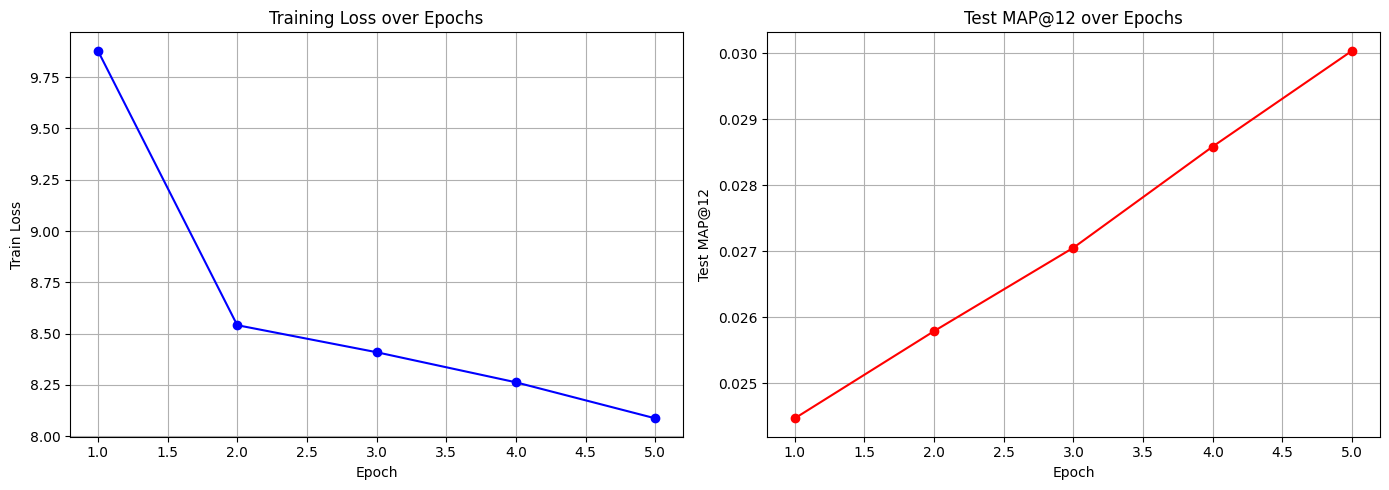


Training curves saved to 'training_results.png'


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 'b-o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss')
ax1.set_title('Training Loss over Epochs')
ax1.grid(True)

# MAP@12
ax2.plot(range(1, len(history['test_map']) + 1), history['test_map'], 'r-o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test MAP@12')
ax2.set_title('Test MAP@12 over Epochs')
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining curves saved to 'training_results.png'")

Sample Predictions

In [ ]:
# Montrer quelques exemples de predictions
print("\nSample Predictions:\n")

model.eval()
sample_users = list(test_targets.keys())[:5]

with torch.no_grad():
    for i, user_id in enumerate(sample_users, 1):
        if user_id not in user_sequences:
            continue
        
        # Historique
        seq = user_sequences[user_id]
        encoded_seq = [article_to_idx.get(art, 0) for art in seq]
        encoded_seq = [x for x in encoded_seq if x != 0]
        
        if len(encoded_seq) == 0:
            continue
        
        if len(encoded_seq) > config.max_seq_len:
            encoded_seq = encoded_seq[-config.max_seq_len:]
        
        padded_seq = [0] * (config.max_seq_len - len(encoded_seq)) + encoded_seq
        mask = [True] * (config.max_seq_len - len(encoded_seq)) + [False] * len(encoded_seq)
        
        input_seq = torch.LongTensor([padded_seq]).to(device)
        mask_tensor = torch.BoolTensor([mask]).to(device)
        
        # Predictions
        top_k_indices = model.predict_top_k(input_seq, mask_tensor, k=12)
        top_k_indices = top_k_indices[0].cpu().numpy()
        
        recommended = [idx_to_article.get(idx, 'Unknown') for idx in top_k_indices]
        actual = test_targets[user_id]
        
        print(f"User {i}:")
        print(f"  Last 3 purchases in history: {seq[-3:]}")
        print(f"  Actually bought in test: {actual}")
        print(f"  Top 12 recommendations: {recommended}")
        
        # Calculer hits
        hits = [art for art in recommended if art in actual]
        print(f"  Hits: {hits if hits else 'None'}")
        print()


Sample Predictions:

User 1:
  Last 3 purchases in history: [880017001, 880017001, 889036004]
  Actually bought in test: [827487003]
  Top 12 recommendations: [np.int64(889036004), np.int64(850917001), np.int64(895837002), np.int64(903926001), np.int64(923037001), np.int64(751471001), np.int64(884319006), np.int64(751471038), np.int64(914805002), np.int64(921298001), np.int64(898713001), np.int64(874891003)]
  Hits: None

User 2:
  Last 3 purchases in history: [576897001, 816588001, 732842015]
  Actually bought in test: [757926001, 788575004, 640021019]
  Top 12 recommendations: [np.int64(732842015), np.int64(685814001), np.int64(858883001), np.int64(921226002), np.int64(717490008), np.int64(717490010), np.int64(852584001), np.int64(803757014), np.int64(754238024), np.int64(919499007), np.int64(621381012), np.int64(870328001)]
  Hits: None

User 3:
  Last 3 purchases in history: [865799005, 456163060, 933989002]
  Actually bought in test: [903762001, 879189005, 158340001, 867966009, 9

In [ ]:
# Verifier combien de customers ont un historique dans train
customers_with_history = set(user_sequences.keys())
customers_to_predict = set(all_customers)

overlap = customers_with_history.intersection(customers_to_predict)
cold_start = customers_to_predict - customers_with_history

print(f"\nCustomer coverage analysis:")
print(f"  Customers with purchase history: {len(overlap)} ({len(overlap)/len(all_customers)*100:.1f}%)")
print(f"  Cold start customers (no history): {len(cold_start)} ({len(cold_start)/len(all_customers)*100:.1f}%)")


Customer coverage analysis:
  Customers with purchase history: 158275 (11.5%)
  Cold start customers (no history): 1213705 (88.5%)


In [ ]:
# Compter les achats dans la periode recente (dernier mois de train)
recent_date = train_transactions['t_dat'].max()
one_month_ago = recent_date - timedelta(days=30)
recent_transactions = train_transactions[train_transactions['t_dat'] >= one_month_ago]

# Top articles par popularite
article_counts = recent_transactions['article_id'].value_counts()
top_popular_articles = article_counts.head(12).index.tolist()

print(f"Top 12 popular articles: {top_popular_articles[:5]}...")

Top 12 popular articles: [751471001, 706016001, 751471043, 918292001, 915529003]...


In [ ]:
@torch.no_grad()
def predict_for_customer(customer_id, model, user_sequences, article_to_idx, idx_to_article, 
                         top_popular_articles, device, k=12):
    """
    Genere 12 recommandations pour un customer
    
    Si le customer a un historique: utilise le modele
    Sinon (cold start): retourne les articles populaires
    """
    
    # Cas 1: Customer avec historique
    if customer_id in user_sequences:
        seq = user_sequences[customer_id]
        encoded_seq = [article_to_idx.get(art, 0) for art in seq]
        encoded_seq = [x for x in encoded_seq if x != 0]
        
        if len(encoded_seq) > 0:
            # Preparer input
            if len(encoded_seq) > config.max_seq_len:
                encoded_seq = encoded_seq[-config.max_seq_len:]
            
            padded_seq = [0] * (config.max_seq_len - len(encoded_seq)) + encoded_seq
            mask = [True] * (config.max_seq_len - len(encoded_seq)) + [False] * len(encoded_seq)
            
            input_seq = torch.LongTensor([padded_seq]).to(device)
            mask_tensor = torch.BoolTensor([mask]).to(device)
            
            # Prediction
            top_k_indices = model.predict_top_k(input_seq, mask_tensor, k=k)
            top_k_indices = top_k_indices[0].cpu().numpy()
            
            # Convertir en article_ids
            recommendations = []
            for idx in top_k_indices:
                article = idx_to_article.get(idx, None)
                if article is not None:
                    recommendations.append(article)
            
            # Si pas assez de recommendations, completer avec populaires
            if len(recommendations) < k:
                for pop_art in top_popular_articles:
                    if pop_art not in recommendations:
                        recommendations.append(pop_art)
                        if len(recommendations) >= k:
                            break
            
            return recommendations[:k]
    
    # Cas 2: Cold start - retourner articles populaires
    return top_popular_articles[:k]

print("Prediction function defined")

Prediction function defined


In [ ]:
print("\nGenerating predictions for all customers...")
print("This may take several minutes...\n")

model.eval()
predictions = []

total_customers = len(all_customers)
batch_log_interval = 10000

for idx, customer_id in enumerate(all_customers, 1):
    # Generer 12 recommandations
    recommended_articles = predict_for_customer(
        customer_id, 
        model, 
        user_sequences, 
        article_to_idx, 
        idx_to_article,
        top_popular_articles,
        device,
        k=12
    )
    
    # Formatter: articles separes par des espaces
    prediction_str = ' '.join([str(art) for art in recommended_articles])
    
    predictions.append({
        'customer_id': customer_id,
        'prediction': prediction_str
    })
    
    # Log progress
    if idx % batch_log_interval == 0:
        print(f"  Processed {idx}/{total_customers} customers ({idx/total_customers*100:.1f}%)")

print(f"\nCompleted predictions for {len(predictions)} customers")


Generating predictions for all customers...
This may take several minutes...

  Processed 10000/1371980 customers (0.7%)
  Processed 20000/1371980 customers (1.5%)
  Processed 30000/1371980 customers (2.2%)
  Processed 40000/1371980 customers (2.9%)
  Processed 50000/1371980 customers (3.6%)
  Processed 60000/1371980 customers (4.4%)
  Processed 70000/1371980 customers (5.1%)
  Processed 80000/1371980 customers (5.8%)
  Processed 90000/1371980 customers (6.6%)
  Processed 100000/1371980 customers (7.3%)
  Processed 110000/1371980 customers (8.0%)
  Processed 120000/1371980 customers (8.7%)
  Processed 130000/1371980 customers (9.5%)
  Processed 140000/1371980 customers (10.2%)
  Processed 150000/1371980 customers (10.9%)
  Processed 160000/1371980 customers (11.7%)
  Processed 170000/1371980 customers (12.4%)
  Processed 180000/1371980 customers (13.1%)
  Processed 190000/1371980 customers (13.8%)
  Processed 200000/1371980 customers (14.6%)
  Processed 210000/1371980 customers (15.3%

In [ ]:
submission_df = pd.DataFrame(predictions)

print(f"\nSubmission DataFrame:")
print(f"  Shape: {submission_df.shape}")
print(f"  Columns: {submission_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(submission_df.head())
print(f"\nLast few rows:")
print(submission_df.tail())


Submission DataFrame:
  Shape: (1371980, 2)
  Columns: ['customer_id', 'prediction']

First few rows:
                                         customer_id  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   

                                          prediction  
0  751471001 706016001 751471043 918292001 915529...  
1  751471001 706016001 751471043 918292001 915529...  
2  751471001 706016001 751471043 918292001 915529...  
3  751471001 706016001 751471043 918292001 915529...  
4  751471001 706016001 751471043 918292001 915529...  

Last few rows:
                                               customer_id  \
1371975  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...   
1371976  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...   
1371977  ffffcf35913a0bee60e

In [ ]:
# Verifications critiques
print("\n" + "="*60)
print("VERIFICATION BEFORE SAVING")
print("="*60)

# 1. Nombre de lignes
expected_rows = len(sample_submission)
actual_rows = len(submission_df)
print(f"\n1. Number of rows:")
print(f"   Expected: {expected_rows}")
print(f"   Actual: {actual_rows}")
print(f"   Status: {'OK' if expected_rows == actual_rows else 'ERROR'}")

# 2. Colonnes
expected_cols = ['customer_id', 'prediction']
actual_cols = submission_df.columns.tolist()
print(f"\n2. Columns:")
print(f"   Expected: {expected_cols}")
print(f"   Actual: {actual_cols}")
print(f"   Status: {'OK' if expected_cols == actual_cols else 'ERROR'}")

# 3. Customer IDs correspondent
expected_ids = set(sample_submission['customer_id'])
actual_ids = set(submission_df['customer_id'])
print(f"\n3. Customer IDs match:")
print(f"   Status: {'OK' if expected_ids == actual_ids else 'ERROR'}")

# 4. Nombre d'articles par prediction
def count_articles(pred_str):
    return len(pred_str.split())

submission_df['num_articles'] = submission_df['prediction'].apply(count_articles)
print(f"\n4. Number of articles per prediction:")
print(f"   Min: {submission_df['num_articles'].min()}")
print(f"   Max: {submission_df['num_articles'].max()}")
print(f"   Mode: {submission_df['num_articles'].mode()[0]}")
print(f"   Status: {'OK' if submission_df['num_articles'].min() == 12 else 'WARNING: Some predictions have < 12 articles'}")

# Supprimer la colonne temporaire
submission_df = submission_df.drop('num_articles', axis=1)

# 5. Pas de valeurs manquantes
null_count = submission_df.isnull().sum().sum()
print(f"\n5. Missing values:")
print(f"   Count: {null_count}")
print(f"   Status: {'OK' if null_count == 0 else 'ERROR'}")


VERIFICATION BEFORE SAVING

1. Number of rows:
   Expected: 1371980
   Actual: 1371980
   Status: OK

2. Columns:
   Expected: ['customer_id', 'prediction']
   Actual: ['customer_id', 'prediction']
   Status: OK

3. Customer IDs match:
   Status: OK

4. Number of articles per prediction:
   Min: 12
   Max: 12
   Mode: 12
   Status: OK

5. Missing values:
   Count: 0
   Status: OK


In [ ]:
# Sauvegarder le fichier
output_filename = 'submission.csv'
submission_df.to_csv(output_filename, index=False)

print(f"\n" + "="*60)
print("SUBMISSION FILE SAVED")
print("="*60)
print(f"\nFile: {output_filename}")
print(f"Size: {os.path.getsize(output_filename) / 1024 / 1024:.2f} MB")

# Verifier le fichier sauvegarde
saved_df = pd.read_csv(output_filename)
print(f"\nVerification of saved file:")
print(f"  Rows (excluding header): {len(saved_df)}")
print(f"  Columns: {saved_df.columns.tolist()}")

print(f"\n{'='*60}")
print("READY FOR SUBMISSION TO KAGGLE")
print(f"{'='*60}")



SUBMISSION FILE SAVED

File: submission.csv
Size: 243.37 MB

Verification of saved file:
  Rows (excluding header): 1371980
  Columns: ['customer_id', 'prediction']

READY FOR SUBMISSION TO KAGGLE


In [ ]:
# Montrer quelques exemples
print("\nSample predictions:\n")

for i in range(5):
    row = submission_df.iloc[i]
    customer_id = row['customer_id']
    articles = row['prediction'].split()
    
    # Verifier si le customer avait un historique
    has_history = customer_id in user_sequences
    
    print(f"Customer {i+1}: {customer_id}")
    print(f"  Has purchase history: {has_history}")
    if has_history:
        history = user_sequences[customer_id]
        print(f"  Last 3 purchases: {history[-3:]}")
    print(f"  Predicted articles: {articles}")
    print()


Sample predictions:

Customer 1: 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657
  Has purchase history: False
  Predicted articles: ['751471001', '706016001', '751471043', '918292001', '915529003', '915526001', '896152002', '916468003', '448509014', '863595006', '898694001', '850917001']

Customer 2: 0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa
  Has purchase history: False
  Predicted articles: ['751471001', '706016001', '751471043', '918292001', '915529003', '915526001', '896152002', '916468003', '448509014', '863595006', '898694001', '850917001']

Customer 3: 000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318
  Has purchase history: False
  Predicted articles: ['751471001', '706016001', '751471043', '918292001', '915529003', '915526001', '896152002', '916468003', '448509014', '863595006', '898694001', '850917001']

Customer 4: 00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e
  Has purchase history: False
  Predicte